## **Vehicle Detection Project**   
---

The goals / steps of this project are the following:

* [**Step 0: Make a list of image to read in.**](#jump0)    
* [**step 1: Explore the Training Data.**](#jump1)    
    * Visualize Some Training Data    
    * Define draw rectangle function and show mamual rectangle onto image    
    * Template Matching
    * Histograms of Color
    * Explore Color Spaces
    * Spatial Binning of Color
* [**Step 2: Define Method to Get Histogram of Oriented Gradients (HOG) Features.**](#jump2)
    * Define get hog features function & Visualize HOG on example image   
    * Extract HOG Features from an Array of Car and Non-Car Images   
    * Combine and Normalize Features
    * Color Classify   
    * HOG Classify   
    * Color and Hog Feature Combined Function
    * Extract Features
* [**Step 3: Train Classifier and Save Parameters.**](#jump3)
    * Train classifer
    * Save model parameters
    * Restore model parameters
* [**Step 4: Method for Using Classifier to Detect Cars in an Image.**](#jump4)
    * Dectet car position
    * Search object and classify
    * Hog Sub-sampling Window Search
    * Show All Potential Search Areas
    * Heat map Filtering
* [**Step 5:  Pipeline for Processing Video Frames**](#jump5)
    * Define Vechile dectect Class
    * Show Test Results
    * Test on Videos
* [**Stemp 6: Discussion.**](#jump6)

---
# <span id="jump0">Step 0: Make a list of image to read in .</span>    

In [38]:
# -*- coding=UTF-8 -*-
import numpy as np
import cv2
import sklearn
import skimage
import glob
import os
import time
import math
import random
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler

# NOTE: : the next import is only valid for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# for scikit-learn version <= 0.17 
#from sklearn.cross_validation import train_test_split

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

print('OK!')

OK!


In [39]:
car_images = glob.glob('Data/vehicles/**/*.png')
noncar_images = glob.glob('Data/non-vehicles/**/*.png')
car_images_num = len(car_images)
noncar_images_num = len(noncar_images)
print("Vehicles images = ", car_images_num)
print("Non Vehicles images = " , noncar_images_num)

Vehicles images =  8792
Non Vehicles images =  8968


------
# <span id="jump1">Step 1: Explore the Training Data .</span>    

- ## Visualize Some Training Data

In [40]:
def show_images(images, lable=None, cols=3, figsize=(14, 14), cmap=None, ticksshow=False):
    """
    Show images
    
    Arguments:
        iamges: source images array like/list. or image files list. Here uses iterate
        label: the image relevant label, list or array like
        cols: show images per colum
        cmap: color map
        ticksshow: bool, whether show ticks
    """
    rows = (len(images)+cols-1)//cols 
#     if cols >= 8:
#         plt.figure(figsize=(14, 8))
#     else:
#         plt.figure(figsize=(14,14))
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        if isinstance(image, str):  # or (type(image)== str) check the image type, if == str ,then read it
            image = mpimg.imread(image)
        plt.subplot(rows, cols, i+1)
        
        # use gray scale color map if there is only one channel   
        showimage_shape = image.shape

        if len(showimage_shape) == 2: 
            cmap = "gray"
        elif  showimage_shape[2] == 1:
            image = image[:,:,0]
            cmap = "gray"
        
        plt.imshow(image, cmap=cmap)
        if lable != None and lable[i] != None:
            plt.title(lable[i],fontsize=14)
            
        if ticksshow != True:
            plt.xticks([])
            plt.yticks([])
            
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

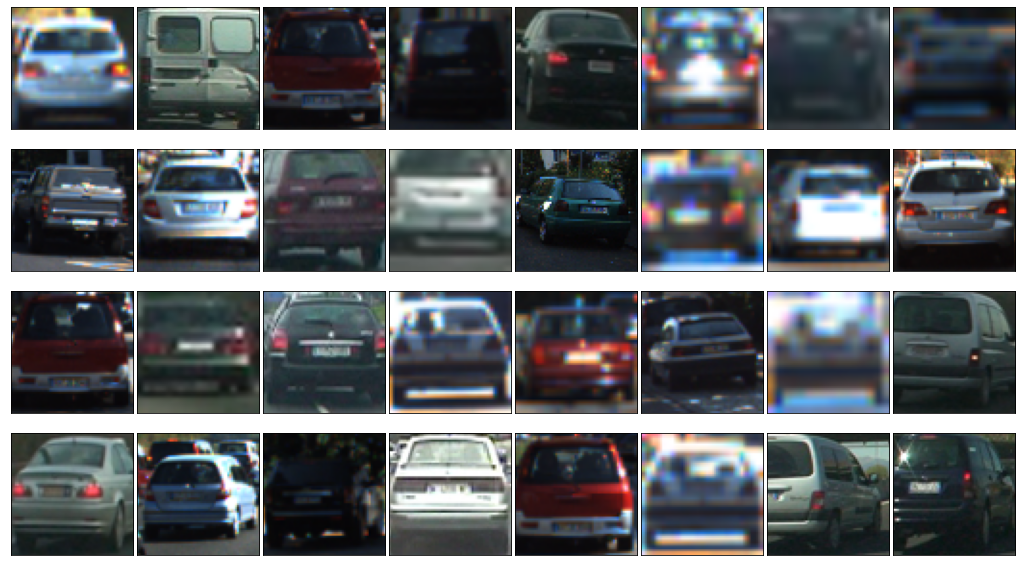

In [41]:
imgs_32 = random.sample(car_images, 32)
show_images(imgs_32, lable=None, cols=8, figsize=(14,8),cmap=None, ticksshow=False)

   
   
- ## Define draw rectangle function and show mamual  rectangle onto image

In [42]:
# Here is your draw_boxes function from the 'Manual Vehicle Detection' lesson
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    """
    Draw bounding box
    
    Arguments:
        img: source image array like/list. or image files list
        bboxes: bounding box diagonal coordinates
        color: one color or random color if "random"
        thick: line Diagonal coordinates
    """
    # Make a copy of the image
    if isinstance(img, str): # check che type of img, if equal str, read it
        img = mpimg.imread(img)
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('OK')

OK


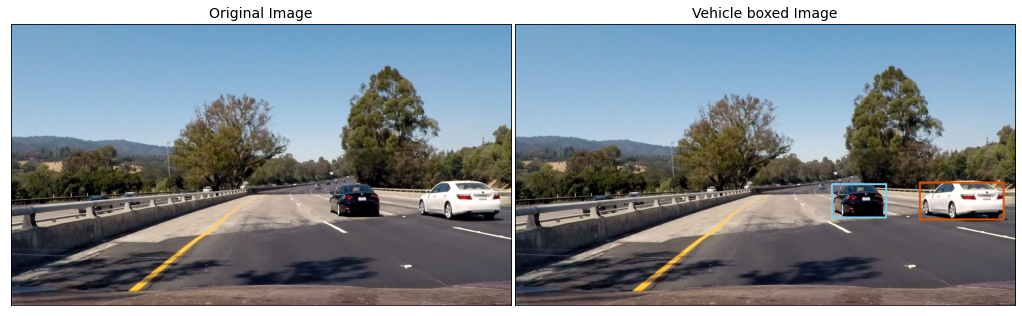

In [43]:
image = 'test_images/test4.jpg'
# Here are the bounding boxes I used
bboxes = [((809, 411), (948, 496)), ((1034, 407), (1248, 501))]

result = draw_boxes(image, bboxes,"random")

show_images([image, result],['Original Image','Vehicle boxed Image'],cols = 2)

- ## Template Matching   
   Template matching take in an image and a list of templates, return a list of the beat fit location for each template in the image.   
   
   OpenCV provides with the handy function **`cv2.matchTemplate()`** to search the image, and **`cv2.minMaxLoc()`** to extract the location of the best match. 
   
   *You can choose between "squared difference" or "correlation" methods in using cv2.matchTemplate(), but keep in mind with squared differences you need to locate the global minimum difference to find a match, while for correlation, you're looking for a global maximum.*

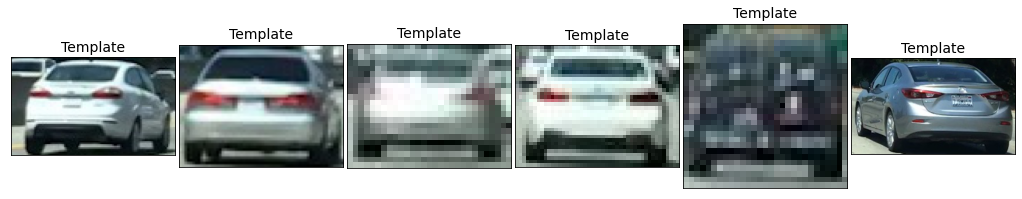

In [44]:
image = mpimg.imread('tempmatch_images/bbox-example-image.jpg')

templist = ['tempmatch_images/cutout1.jpg', 'tempmatch_images/cutout2.jpg', 'tempmatch_images/cutout3.jpg',
            'tempmatch_images/cutout4.jpg', 'tempmatch_images/cutout5.jpg', 'tempmatch_images/cutout6.jpg']    

show_images(templist,len(templist)*['Template'],cols = len(templist))

In [45]:
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates

def find_matches(img, template_list, method=cv2.TM_CCORR_NORMED):
    """
    Using template match the image to find object
    
    Arguments:
        img: source image array like. or image file name
        template_list: template list
        method: method
    """
    if isinstance(img, str):
        img = mpimg.imread(img)
    # Define an empty list to take bbox coords
    bbox_list = []
    
    # Iterate through template list
    for temp in template_list:
        if isinstance(temp, str):
            tmp = mpimg.imread(temp)
            
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list

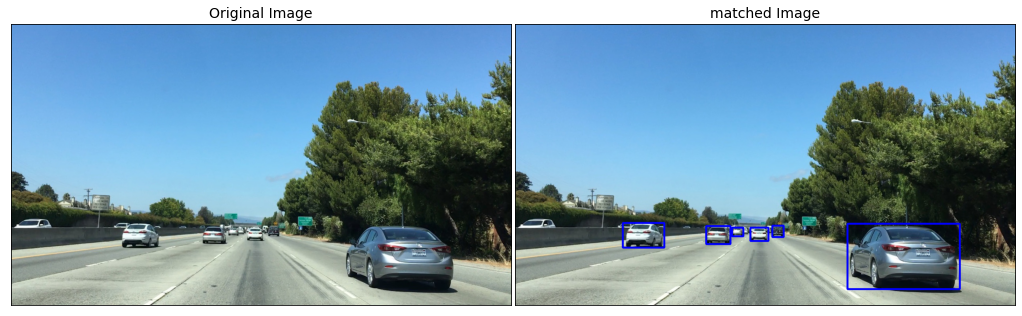

In [46]:
method = cv2.TM_CCORR_NORMED
# Define matching method
# Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR','cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)

show_images([image,result], ['Original Image', 'matched Image'], cols = 2)

- ## Histograms of Color

*Some code for this method was mostly duplicated from course lesson material.*  

Histograms of color statistic raw pixel intensites in one color sapce.   

With [*`np.histogram()`*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html), we don't actually have to specify the number of bins or the range, but here I've arbitrarily chosen 32 bins and specified range=(0, 256) in order to get orderly bin sizes. *`np.histogram()`* returns a tuple of two arrays. In this case, for example, *`rhist[0]`* contains the counts in each of the bins and *`rhist[1]`* contains the bin edges (so it is one element longer than *`rhist[0]`*).

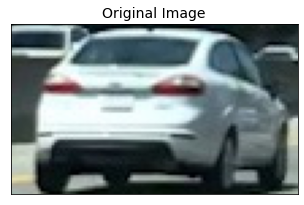

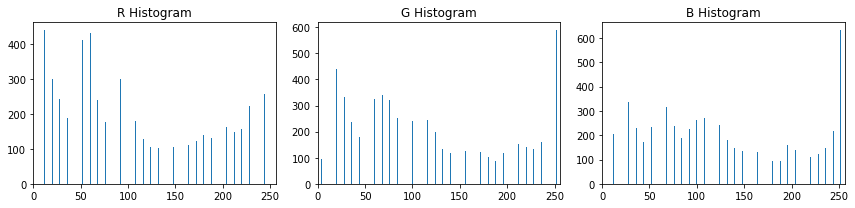

In [47]:
img_cutout = "./tempmatch_images/cutout1.jpg"

show_images([img_cutout],['Original Image'], figsize=(12,12)) # NOTO: Using [img_cutout] instead of img_cutout

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), colorspace='RGB'):
    """
    Compute color histogram
    
    Arguments:
        img: sourece image array like or image file name
        nbins: int, it defines the number of equal-width bins in the given range.
        bins_range: The lower and upper range of the bins
        colorspace: color space
    """
    if isinstance(img, str): # check che type of img, if equal str, read it
        img = mpimg.imread(img)
    
    if colorspace != 'RGB':
        if colorspace == 'HSV':
            dst_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif colorspace == 'LUV':
            dst_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif colorspace == 'HLS':
            dst_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif colorspace == 'YUV':
            dst_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif colorspace == 'YCrCb':
            dst_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        dst_img = np.copy(img)
    
    # Compute the histogram of the RGB channels separately
    hist_0 = np.histogram(dst_img[:,:,0], bins=nbins, range=bins_range)
    hist_1 = np.histogram(dst_img[:,:,1], bins=nbins, range=bins_range)
    hist_2 = np.histogram(dst_img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist_0[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist_0[0], hist_1[0], hist_2[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_0, hist_1, hist_2, bin_centers, hist_features


rh, gh, bh, bincen, feature_vec = color_hist(img_cutout, 32, (0, 256), 'RGB')

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

- ## Explore Color Spaces 

*The code for this method was mostly duplicated from course lesson material.*

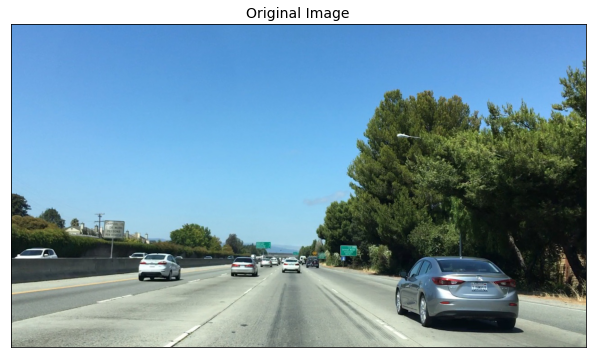

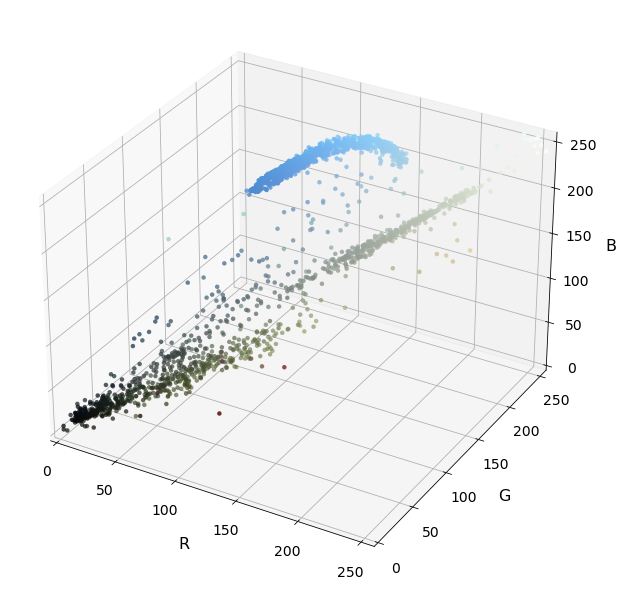

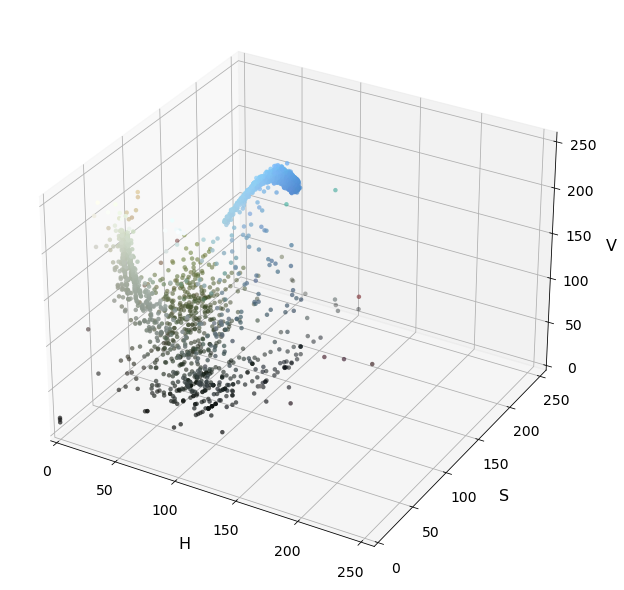

In [48]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = mpimg.imread("./tempmatch_images/bbox-example-image.jpg")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = np.copy(img_small)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

show_images([img], ['Original Image'], figsize=(24, 24))

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

- ## Spatial Binning of Color

    *Some code for this method was mostly duplicated from course lesson material.* 

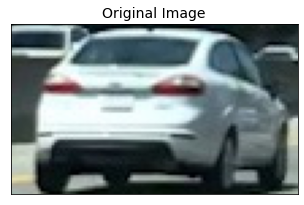

Text(0.5, 1.0, 'Spatially Binned Features')

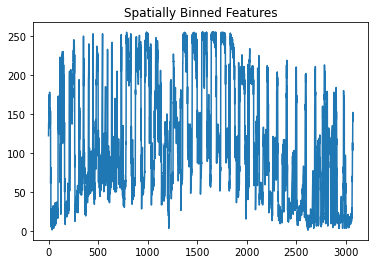

In [49]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # check che type of img, if equal str, read it
    if isinstance(img, str): 
        img = mpimg.imread(img)
        
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('tempmatch_images/cutout1.jpg')
show_images([image],['Original Image'], figsize=(12,12))
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

---
# <span id="jump2">Step 2: Define Method to Get Histogram of Oriented Gradients (HOG) Features. </span>   
*This method was duplicated from lesson materials*

---
- ## Define get hog features function & Visualize HOG on example image

In [50]:
# Define HOG parameters
orient = 11
pix_per_cell = 16
cell_per_block = 2
vis=False
feature_vec=True

def get_hog_features(img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                     vis=vis, feature_vec=feature_vec):
    """
    Extract one image HOG feature
    
    Arguments:
        img: source images
        orient: split 360˚ into orient parts
        pix_per_cell: pixels per cell
        cell_per_block: cells per block
        vis: bool, whether visualize the result
        feature_vec: bool, whether tansfer hog features into vector
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### Visualize HOG on example image

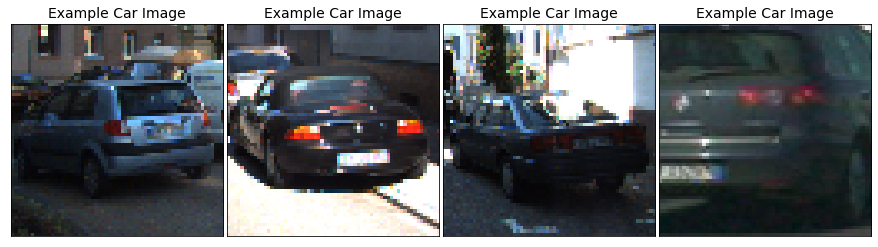

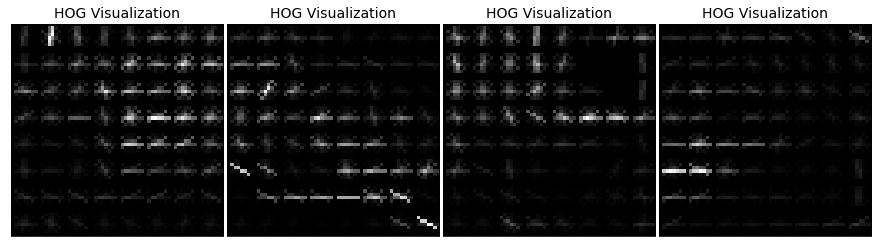

In [51]:
def rgb2gray(img):
    # check che type of img, if equal str, read it
    if isinstance(img, str): 
        img = mpimg.imread(img)
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

car_imgs_4 = random.sample(car_images, 4)

gray_car_image = list(map(rgb2gray, car_imgs_4))

res = list(map(lambda img:hog(img,visualize=True), gray_car_image))

car_features = [s[0] for s in res]
car_hog_image = [s[1] for s in res]

show_images(car_imgs_4, 4 * ['Example Car Image'], cols = 4, figsize=(12,12)) 
show_images(car_hog_image,4 * ['HOG Visualization'], cols = 4, figsize=(12,12)) 

- ## Combine and Normalize Features

    I am almost ready to train a classifier, but first, as in any machine learning application, we need to normalize your data. Python's `sklearn` package provides you with the *`StandardScaler()`* method to accomplish this task. To read more about how you can choose different normalizations with the *`tandardScaler()`* method, check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

    To apply *`StandardScaler()`* we need to first have our data in the right format, as a numpy array where each row is a single feature vector. 

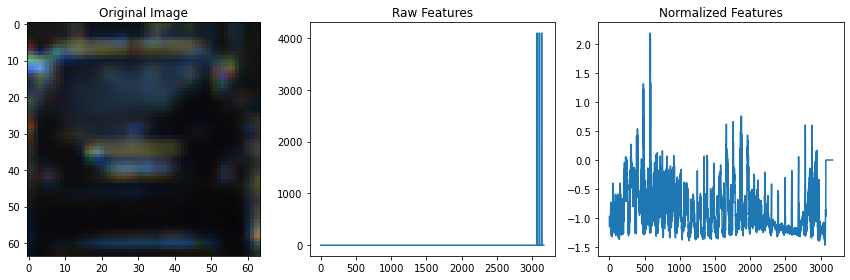

In [52]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_with_spatial_histogram(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, 
                                            hist_range=(0, 256)):
    """
    Extract spatial and histogram feature of series images
    
    Arguments:
        imgs: source images array like. or image files name
        cspace: color space HSV, RGB, HLS, YUV, YCrCb
        orient: split 360˚ into orient parts
        pix_per_cell: pixels per cell
        cell_per_block: cells per block
        hog_channel: which channel of image to extract HOG features
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        if isinstance(file, str):
            image = mpimg.imread(file)
        else:
            image = np.copy(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: 
            feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now, NOTE: return (4,) tuple
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features[4]))) 
    # Return list of feature vectors
    return features
        
car_features = extract_features_with_spatial_histogram(car_images)
notcar_features = extract_features_with_spatial_histogram(noncar_images)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

- ## Color Classify

In [53]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:', 32, 'and', 32,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
40.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9169
My SVC predicts:  [1. 1. 0. 0. 1. 0. 0. 1. 0. 1.]
For these 10 labels:  [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
0.01396 Seconds to predict 10 labels with SVC


- ## HOG Classifer

    *The code for this method was mostly duplicated from course lesson material.*

In [67]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_HOG_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """
    Extract HOG feature of series images
    
    Arguments:
        imgs: source images array like. or image files name
        cspace: color space HSV, RGB, HLS, YUV, YCrCb
        orient: split 360˚ into orient parts
        pix_per_cell: pixels per cell
        cell_per_block: cells per block
        hog_channel: which channel of image to extract HOG features
    """
    # Create a list to append feature vectors
    features = []
    # Iterate in each image one by one
    for file in imgs:
        # Read in each image one by one
        image = mpimg.imread(file)
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                                     cell_per_block, vis=False, feature_vec=True))
            
            hog_features = np.ravel(hog_features)
            
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell,
                                            cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of images feature vecotors
    return features



### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_HOG_features(car_images,cspace=colorspace, orient=orient,  pix_per_cell=pix_per_cell,
                                      cell_per_block=cell_per_block,hog_channel=hog_channel)
notcar_features = extract_HOG_features(noncar_images, cspace=colorspace, orient=orient,  pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block,hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

TypeError: hog() got an unexpected keyword argument 'visualise'

- ## Color and Hog Feature Combined Function

    Combine color and hog features to train classifer

In [55]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract HOG feature of series images
    
    Arguments:
        imgs: source images array like. or image files name
        cspace: color space HSV, RGB, HLS, YUV, YCrCb
        orient: split 360˚ into orient parts
        pix_per_cell: pixels per cell
        cell_per_block: cells per block
        hog_channel: which channel of image to extract HOG features
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        if isinstance(file, str):
            image = mpimg.imread(file)
        else:
            image = np.copy(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() NOTE: return (4,) tuple
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features[4])
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

- ## Extract Features

In [56]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
t = time.time()
car_features = extract_features(car_images, cspace=color_space, spatial_size=spatial_size, 
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, cspace=color_space, spatial_size=spatial_size, 
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

TypeError: hog() got an unexpected keyword argument 'visualise'

---
# <span id="jump3">Step 3: Train Classifier and Save Parameters. </span>   
Train svc classifer and save paramters.
    
---  
- ## Train SVC classifer

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

- ## Save model parameters

In [57]:
# Save the parameters
save_file = "svc_pickle.p"

dist_pickle = {}
dist_pickle["color_space"] = color_space
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["hog_channel"] = hog_channel
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
pickle.dump( dist_pickle, open(save_file , "wb" ) )

- ## Restore SVC model parameters

In [58]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

color_space = dist_pickle["color_space"]
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"] 
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"] 

---
# <span id="jump4">Step 4: Method for Using Classifier to Detect Cars in an Image .</span>    

*This code is adapted from lesson material*

<img src="./readme_img/hog-visualization.jpg" width = "500" height = "400" alt="HOG Visualization" align=center />

- ## Dectet Car position

In [59]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Slide window
    
    Arguments:
        img: source image array like or image file image
        x_start_stop: column, Horizontal coordinate from x_start_stop[0] to x_start_stop[1]
        y_start_stop: row, Vertical coordinate begin with y_start_stop[0] and end with y_start_stop[1]
        xy_window: pixel
        xy_overlap: overlap percent 
        
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

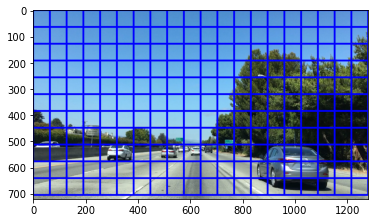

In [60]:
## Test function
image = mpimg.imread('tempmatch_images/bbox-example-image.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(128, 128), 
                       xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)    
plt.imshow(window_img)

- ## Search object and classify

In [61]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, cspace='RGB', spatial_size=(32, 32),hist_bins=32, orient=9, pix_per_cell=8, 
                        cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features[4])
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                     cell_per_block, vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                            cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace ='RGB', spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, spatial_size=spatial_size, 
                                       hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [62]:
image = mpimg.imread('tempmatch_images/bbox-example-image.jpg')

draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

y_start_stop = [400, 700] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), 
                       xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, cspace=color_space, spatial_size=spatial_size, 
                             hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                             cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                             hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

TypeError: hog() got an unexpected keyword argument 'visualise'

   
   
   
- ## Hog Sub-sampling Window Search

    Using a 64 x 64 base window. If we define cells per pixel as 8 x 8, then a scale of 1 would retain a window that's 8 x 8 cells (8 cells to cover 64 pixels in either direction). An overlap of each window can be defined in terms of the cell distance, using cells_per_step. This means that a cells_per_step = 2 would result in a search window overlap of 75% (2 is 25% of 8, so we move 25% each time, leaving 75% overlap with the previous window). 
    
    Any value of scale that is larger or smaller than one will scale the base image accordingly, resulting in corresponding change in the number of cells per window. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.
    
    <img src="./readme_img/hog-sub.jpg" width = "500" height = "400" alt="HOG Visualization" align=center />


In [ ]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
              hist_bins, cells_per_step=2, boxcolor=(0,0,255), show_all_rectangles=False):
    """
    Find cars in the area
    
    Arguments:
        img: source image
        ystart: row begin to search
        ystop: row stop to search
        scale: rescale image
        cspace: color space
        hog_channel: which channel of image to extract HOG features
        svc: SVM Classifier
        orient: split 360˚ into orient parts
        pix_per_cell: pixels per cell
        cell_per_block: cells per block
        show_all_rectangles: bool, whether show all rectangles
    """
    if isinstance(img, str):
        img = mpimg.imread(img)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 # 有重叠部分
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # bording box of dected cars
    rectangles = []
    random_color = False
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch, HOG feature array output：(n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient)
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features[4], hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if boxcolor == 'random' or random_color:
                    boxcolor = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
                    random_color = True
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),boxcolor,3) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return img_tosearch, draw_img, rectangles

   
   
   
- ## Show All Potential Search Areas

ecuase the size and position of cars in the image will be different depending on their distance from the camera, find_cars will have to be called a few times with different ystart, ystop, and scale values. These next few blocks of code are for determining the values for these parameters that work best.

In [ ]:
img = mpimg.imread('tempmatch_images/bbox-example-image.jpg')

ystart = 400
scale = 3
ystop = 680

clip_img, out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                        cell_per_block, spatial_size, hist_bins, boxcolor='random',
                                        show_all_rectangles=True)

show_images([clip_img,out_img],['Cliped Image: y = [%d, %d]'%(ystart, ystop),'Searched Image'],cols = 2,ticksshow = True)

ystart = 400
scale = 2
ystop = 656

clip_img, out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                        cell_per_block, spatial_size, hist_bins, boxcolor='random',
                                        show_all_rectangles=True)

show_images([clip_img,out_img],['Cliped Image: y = [%d, %d]'%(ystart, ystop),'Searched Image'],cols = 2,ticksshow = True)

ystart = 400
scale = 1.5
ystop = 600

clip_img, out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                        cell_per_block, spatial_size, hist_bins, boxcolor='random',
                                        show_all_rectangles=True)

show_images([clip_img,out_img],['Cliped Image: y = [%d, %d]'%(ystart, ystop),'Searched Image'],cols = 2,ticksshow = True)

ystart = 400
scale = 0.8
ystop = 540

clip_img, out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                        cell_per_block, spatial_size, hist_bins, boxcolor='random',
                                        show_all_rectangles=True)

show_images([clip_img,out_img],['Cliped Image: y = [%d, %d]'%(ystart, ystop),'Searched Image'],cols = 2,ticksshow = True)

- ## Heat map Filtering

    To make a heat-map, I'm simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by your classifier. 

In [ ]:
def add_heat(heatmap, bbox_list):
    """
    Compute the area bounding box numbers
    
    Arguments:
        heatmap: array zeros like image
        bbox_list: bou
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    """
    Apply threshold to remove false positives 
    
    Arguments:
        heatmap: heat map
        threshold: threshold
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
    Draw labeled bounding boxes
    
    Arguments:
        img: source image, array like or image file name
        babels: labels
    """
    if isinstance(img, str):
        img = mpimg.imread(img)
        
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def heatmap_filter(img, box_list, threshold=1):
    if isinstance(img, str):
        img = mpimg.imread(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return heatmap, draw_img


def find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler, orient,pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins,cells_per_step, threshold=1, deg_show = True):
    
    clip_img, out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                            cell_per_block, spatial_size, hist_bins, cells_per_step, 
                                            show_all_rectangles=False)
    
    heatmap,draw_img = heatmap_filter(img, box_list, threshold=threshold) 
    
    result = draw_boxes(img, box_list)
    
    if deg_show:
        fig = plt.figure(figsize=(18, 18))
        plt.subplot(141)
        plt.imshow(clip_img)
        plt.title('Area dected')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(142)
        plt.imshow(result)
        plt.title('boxed list Car Positions')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(143)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(144)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)

In [ ]:
img = mpimg.imread('test_images/test5.jpg')
# img = mpimg.imread('test_images/bbox-example-image.jpg')
# img = img.astype(np.float32)/255


ystart = 400
scale = 3
ystop = 680
cells_per_step = 1
threshold = 2

find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins,cells_per_step,threshold=threshold)

ystart = 400
scale = 2
ystop = 656
cells_per_step = 2
threshold = 2

find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins,cells_per_step,threshold=threshold)

ystart = 400
scale = 1.5
ystop = 600
cells_per_step = 2
threshold = 2

find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins,cells_per_step,threshold=threshold)

ystart = 360
scale = 1.2
ystop = 540
cells_per_step = 2
threshold = 3

find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins,cells_per_step,threshold=threshold)

---
# <span id="jump5">Step 5:  Pipeline for Processing Video Frames .</span>  
   
---     
- ## Define Vechile dectect Class

In [ ]:
from collections import deque

class Vechiledectect():
    def __init__(self, maxlen=15):
        
        self.ystart = 400
        self.ystop = 656
        self.scale = 1.5
        self.cells_per_step = 2
        
        dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
        self.svc = dist_pickle["svc"]
        self.X_scaler = dist_pickle["scaler"]
        self.orient = dist_pickle["orient"]
        self.pix_per_cell = dist_pickle["pix_per_cell"]
        self.cell_per_block = dist_pickle["cell_per_block"]
        self.spatial_size = dist_pickle["spatial_size"]
        self.hist_bins = dist_pickle["hist_bins"]
        
        self.spatial_feat = dist_pickle["spatial_feat"]
        self.hist_feat = dist_pickle["hist_feat"]
        self.hog_feat = dist_pickle["hog_feat"] 
        
        self.heatmaps = deque(maxlen = maxlen)
    
    def vechile_find(self, image, debugcombined=True, framenumber=None):
        # multi scale search
        search_parameter = [[400,720,3.0,1],\
                            [400,656,2.0,1],\
                            [400,600,1.5,2],\
                            [400,550,1.0,2],\
                            [400,510,0.8,2]]

        box_lists = []
        for i in range(len(search_parameter)):
            [self.ystart, self.ystop, self.scale, self.cells_per_step] = search_parameter[i]
            
            #rescale recording to image size
            self.ystart = int(image.shape[0]*(self.ystart/720))
            self.ystop = int(image.shape[0]*(self.ystop/720))
            
            clip_img,out_img,box_list = find_cars(image, self.ystart, self.ystop, self.scale, self.svc, self.X_scaler, 
                                                  self.orient, self.pix_per_cell, self.cell_per_block, 
                                                  self.spatial_size, self.hist_bins, self.cells_per_step, 
                                                  boxcolor='random')

            box_lists += box_list

        heat = np.zeros_like(image[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat,box_lists)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,len(search_parameter)+1-1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        self.heatmaps.append(heatmap)

        heatmap = np.mean(self.heatmaps,axis=0)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        if debugcombined == True:
            # Calculate the size of screens
            result_screen_w = image.shape[1]
            result_screen_h = image.shape[0]
            debug_screen_w = np.int(result_screen_w/2)
            debug_screen_h = np.int(result_screen_h/2)
            screen_w = result_screen_w + debug_screen_w
            screen_h = result_screen_h

            # Assign result image to the screen
            #show screen
            screen = np.zeros((screen_h,screen_w,3),dtype=np.uint8)

#             if framenumber != None:
#                 cv2.putText(unwarp_images,'frame index:{:}'.format(framenumber),(10,270),cv2.FONT_HERSHEY_COMPLEX,2,(255,255,255),3)

            screen[0:result_screen_h,0:result_screen_w,:] = draw_img

            result = draw_boxes(image, box_lists)
            # Assign debug image to the screen
            screen[0:debug_screen_h,result_screen_w:,:] = cv2.resize(result,(debug_screen_w,debug_screen_h))

            if np.max(heatmap)> 0:
                debug_img_1 = np.dstack((heatmap,heatmap,heatmap))*int(255/np.max(heatmap))
                screen[debug_screen_h : debug_screen_h*2,result_screen_w:,:] = cv2.resize(debug_img_1,(debug_screen_w,debug_screen_h))

            return screen
        else:
            return draw_img

- ## Show Test Results

In [ ]:
test_images = [plt.imread(path) for path in glob.glob('test_images/test*.jpg')]

for i, image in enumerate(test_images):
    L = Vechiledectect()

    res = L.vechile_find(image)

    fig = plt.figure(figsize=(18, 18))
    plt.imshow(res)


- ## Test on Videos

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
project_source = "project_video.mp4"
project_output = "project_video_output.mp4"


## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
L = Vechiledectect()

clip1 = VideoFileClip(project_source)
line_clip = clip1.fl_image(L.vechile_find) #NOTE: this function expects color images!!
%time line_clip.write_videofile(project_output, audio=False)

In [ ]:
line_clip.resize(height=240).speedx(5).to_gif('project.gif')

<img src="readme_img/project.gif" width = "900" height = "600" alt="Dected result" align=center />

---
# <span id="jump6">Step 7:  Discussion .</span>    

#### From above GIF image, there are some errors in the detected result.

<img src="readme_img/error.jpg" width = "900" height = "600" alt="Dected result" align=center />   

From above image, we can see the left bounding box is wrong.

I select spatial, historgram and hog features to get the svm medel. The above error occurs, I guess, because the spatial and historgram features are not enough to describe the vehicle while the HOG features only take up 1/3 of the whole features.